In [1]:
import arviz as az
import pandas as pd
import seaborn as sns
import os.path as op
import numpy as np

from bauer.utils.math import softplus_np
import matplotlib.pyplot as plt
from bauer.utils.math import softplus_np

from tms_risk.cogmodels.fit_model import build_model, get_data
from tms_risk.cogmodels.utils import plot_ppc
from tms_risk.utils.data import get_subjects, get_all_behavior
from tqdm.contrib.itertools import product
import pingouin


stimulation_palette = sns.color_palette()[2:4]
stimulation_order = ['Vertex', 'IPS']


bids_folder  = '/data/ds-tmsrisk'


def get_info(model_label, bids_folder='/data/ds-tmsrisk'):
    df = get_data(bids_folder, model_label)
    model = build_model(model_label, df)
    model.build_estimation_model()
    idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', f'model-{model_label}_trace.netcdf'))


    return df, model, idata

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df, model, idata = get_info('flexible1')

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


# Get cognitive noise

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_45704/4077195820.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  n1_evidence_sd_ips = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_45704/4077195820.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  n1_evidence_sd_vertex = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1) + pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(5)], 1).values
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_45704/4077195820.py:2: FutureWarning: In a future version of pandas all arguments of concat except for

[(-3.0, 3.0)]

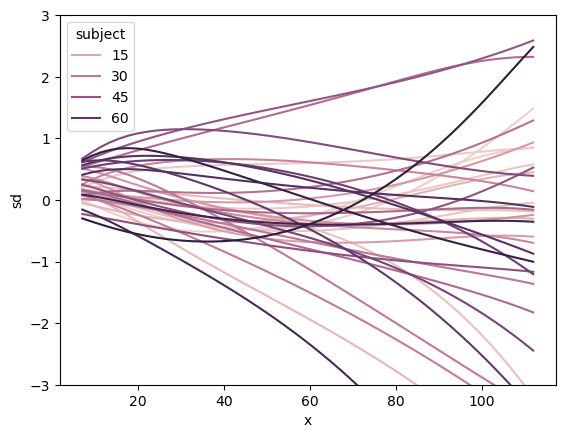

In [3]:
n1_evidence_sd_ips = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)
n1_evidence_sd_vertex = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1) + pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(5)], 1).values

n2_evidence_sd_ips = pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)
n2_evidence_sd_vertex = pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1) + pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(5)], 1).values

x = np.linspace(7, 112)
dm = model.make_dm(x)

def get_curve_posterior(evidence_sd_posterior):
    curve_posterior = evidence_sd_posterior.dot(dm.T)
    curve_posterior.columns = x
    curve_posterior.columns.name = 'x'

    return softplus_np(curve_posterior)

def get_curve_stats(evidence_sd_posterior):
    curve_posterior = get_curve_posterior(evidence_sd_posterior)

    return model.get_sd_curve_stats(curve_posterior.stack().to_frame('sd'))

for d in [n1_evidence_sd_ips, n1_evidence_sd_vertex, n2_evidence_sd_ips, n2_evidence_sd_vertex]:
    d.columns = range(5)

evidence_sd = pd.concat((n1_evidence_sd_ips, n1_evidence_sd_vertex, n2_evidence_sd_ips, n2_evidence_sd_vertex),axis=0,
                        keys=[(1, 'IPS'), (1, 'Vertex'), (2, 'IPS'), (2, 'Vertex')], names=['n', 'TMS'])

curve_posterior = get_curve_posterior(evidence_sd)
curve_stats = evidence_sd.groupby(['n', 'TMS'], group_keys=True).apply(get_curve_stats)

def get_hdi(x):
    return az.hdi(x.values, hdi_prob=.95, circular=False)

diff = curve_posterior.unstack('TMS')

diff = diff.swaplevel(axis=1).sort_index(axis=1)
diff = diff['IPS'] - diff['Vertex']

diff = diff.stack().to_frame('sd')

g = sns.lineplot(diff.reset_index(), x='x', y='sd', hue='subject', errorbar=None) #errorbar=get_hdi, palette=['k'], alpha=.5)


jg.set(ylim=(-3, 3))

<Axes: xlabel='x', ylabel='sd'>

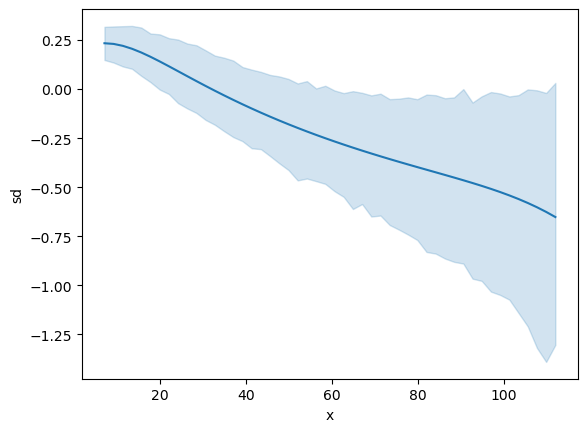

In [4]:
cognitive_noise_diff = diff.groupby(['subject', 'x']).mean()

sns.lineplot(x='x', y='sd', data=cognitive_noise_diff.reset_index())

# Get decoding info

In [5]:
def get_pdf(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    if n_voxels == 1:
        key = 'decoded_pdfs.volume.cv_voxel_selection'
    else:
        key = 'decoded_pdfs.volume'

    subject = f'{subject:02d}'

    if denoise:
        key += '.denoise'

    if smoothed:
        key += '.smoothed'

    if pca_confounds and not denoise:
        key += '.pca_confounds'

    if natural_space:
        key += '.natural_space'

    if n_voxels == 1:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_space-T1w_pars.tsv')
    else:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_nvoxels-{n_voxels}_space-T1w_pars.tsv')

    if op.exists(pdf):
        pdf = pd.read_csv(pdf, sep='\t', index_col=[0,1])
        pdf.columns = pdf.columns.astype(float)

        if natural_space:
            pdf = pdf.loc[:, 5:112]
        else:
            pdf = pdf.loc[:, np.log(5):np.log(112)]
    else:
        print(pdf)
        pdf = pd.DataFrame(np.zeros((0, 0)))
    
    pdf /= np.trapz(pdf, pdf.columns, axis=1)[:, np.newaxis]

    return pdf

def get_decoding_info(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    pdf = get_pdf(subject, session, pca_confounds=pca_confounds, denoise=denoise, smoothed=smoothed, bids_folder=bids_folder, mask=mask, n_voxels=n_voxels, natural_space=natural_space)

    E = pd.Series(np.trapz(pdf*pdf.columns.values[np.newaxis,:], pdf.columns, axis=1), index=pdf.index)

    E = pd.concat((E,), keys=[(int(subject), int(session), 'pca_confounds' if pca_confounds else 'no pca', 'GLMstim' if denoise else "glm", 'smoothed' if smoothed else 'not smoothed', mask, n_voxels,
                                'natural' if natural_space else 'log')],
    names=['subject', 'session', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'space']).to_frame('E')

    
    E['sd'] = np.trapz(np.abs(E.values - pdf.columns.astype(float).values[np.newaxis, :]) * pdf, pdf.columns, axis=1)

    return E


subjects = [int(sub.subject) for sub in get_subjects(all_tms_conditions=True, exclude_outliers=True)]
sessions = [1, 2, 3]
pca_confounds = [False]
denoise = [True]
smoothed = [False]
# masks = ['NPCr1cm-surface', 'NPCr1cm-cluster', 'NPCr2cm-surface', 'NPCr2cm-cluster']
# n_voxels = [0, 1, 100]
masks = ['NPCr2cm-cluster']
n_voxels = [1]
natural_space = [True]


pred = []
pdfs = []
for (sub, session, pcac, den, smooth, mask, nv, ns) in product(subjects, sessions, pca_confounds, denoise, smoothed, masks, n_voxels, natural_space):

    if not ((session == 1) & (nv == 0)):
        pdfs.append(get_pdf(sub, session, pcac, den, smooth, '/data/ds-tmsrisk/', mask, nv, ns))
        pred.append(get_decoding_info(sub, session, pcac, den, smooth, '/data/ds-tmsrisk', mask, nv, ns))

pred = pd.concat(pred)
pdf = pd.concat(pdfs)
df = get_all_behavior(drop_no_responses=False)
pred = pred.join(df, how='inner')
r1 = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['E'], d['n1']))
r2_ = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'run']).apply(lambda d: pingouin.corr(d['E'], d['n1']))
r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean() 

  0%|          | 0/105 [00:00<?, ?it/s]

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')
/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:56: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return pd.concat(behavior)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_45704/3143406941.py:85: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()


In [7]:
decoding_diff = r2.droplevel('session').unstack(['stimulation_condition'])['r']
decoding_diff = (decoding_diff['ips'] - decoding_diff['vertex']).to_frame('decoding_diff') 

<Axes: xlabel='x', ylabel='r'>

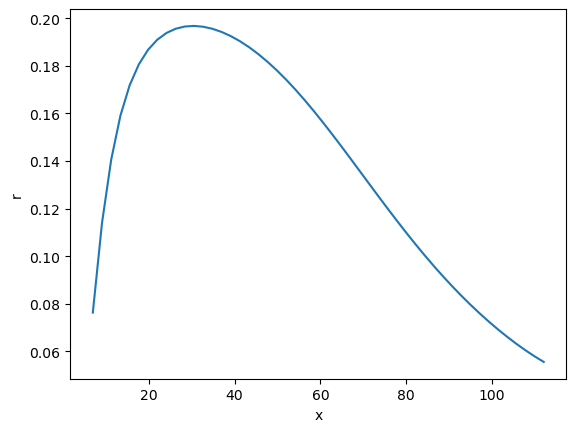

In [12]:
# The worse the decoding (smaller r) after IPS stimulation,
# the more the cognitive noise is dereased ??


tmp = cognitive_noise_diff.groupby('x').apply(lambda d: pingouin.corr(d['sd'], decoding_diff['decoding_diff']))

sns.lineplot(x='x', y='r', data=tmp.reset_index())

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_45704/2730839138.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  decoding_sd_diff = pred.groupby(['subject', 'stimulation_condition']).mean()[['sd']].unstack('stimulation_condition')['sd']


<Axes: xlabel='x', ylabel='r'>

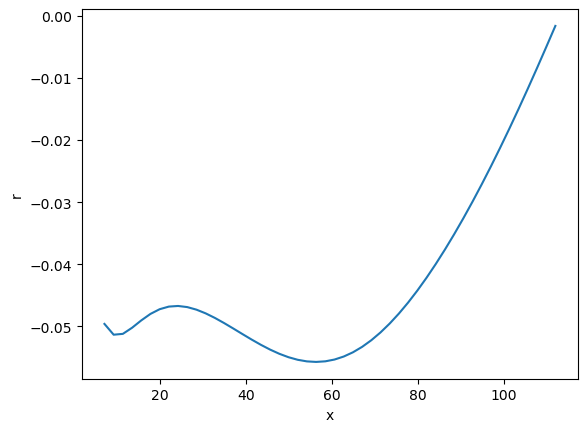

In [13]:
decoding_sd_diff = pred.groupby(['subject', 'stimulation_condition']).mean()[['sd']].unstack('stimulation_condition')['sd']

decoding_sd_diff = (decoding_sd_diff['ips'] - decoding_sd_diff['vertex'])
tmp = cognitive_noise_diff.groupby('x').apply(lambda d: pingouin.corr(d['sd'], decoding_sd_diff))

sns.lineplot(x='x', y='r', data=tmp.reset_index())

In [ ]:
tmp = cognitive_noise_diff.query('(x > 7.) & (x < 20.)').groupby('subject').mean().join(decoding_diff)

pingouin.corr(tmp['sd'], tmp['decoding_diff'])

,n,r,CI95%,p-val,BF10,power
pearson,35,0.154764,"[-0.19, 0.46]",0.374697,0.307,0.14481


# Fisher information

In [114]:
import pandas as pd
import os
import os.path as op
from tms_risk.utils import get_tms_subjects, get_tms_conditions
from tqdm.contrib.itertools import product
import numpy as np
import matplotlib.pyplot as plt
import shutil

bids_folder = '/data/ds-tmsrisk'


def get_fisher_information(subject, session, smoothed, n_voxels=0, bids_folder=bids_folder):

    subject, session = int(subject), int(session)

    key = 'fisher_information.denoise'

    if smoothed:
        key += '.smoothed'

    return pd.read_csv(op.join(bids_folder, 'derivatives', key, f'sub-{subject:02d}', f'ses-{session}', 'func', f'sub-{subject:02d}_ses-{session}_nvoxels-{n_voxels}_fisher_information.tsv'), sep='\t')

subjects = get_tms_subjects(bids_folder)
sessions = [2,3]
smoothed = [True]
n_voxels = [1]

tms_dict = get_tms_conditions()

df = []
keys = []

for subject, session, smooth, nv in product(subjects, sessions, smoothed, n_voxels):
    
    try:
        df.append(get_fisher_information(subject, session, smoothed=smooth, n_voxels=nv))

        keys.append((subject, session, smooth, tms_dict[f'{subject:02d}'][session]))
    except FileNotFoundError as e:
        pass

df = pd.concat(df, keys=keys, names=['subject', 'session', 'smoothed', 'stimulation_condition'])

df['log(fi)'] = np.log(df['Fisher information'] + .1)

  0%|          | 0/70 [00:00<?, ?it/s]

In [115]:
fisher_information_diff = df.groupby(['subject', 'stimulation_condition', 'stimulus']).mean().unstack('stimulation_condition')['log(fi)']

fisher_information_diff = (fisher_information_diff['ips'] - fisher_information_diff['vertex']).to_frame('fisher_information_diff')


In [142]:
fisher_information_diff['fisher_information_diff_smooth'] = fisher_information_diff['fisher_information_diff'].rolling(5).mean()

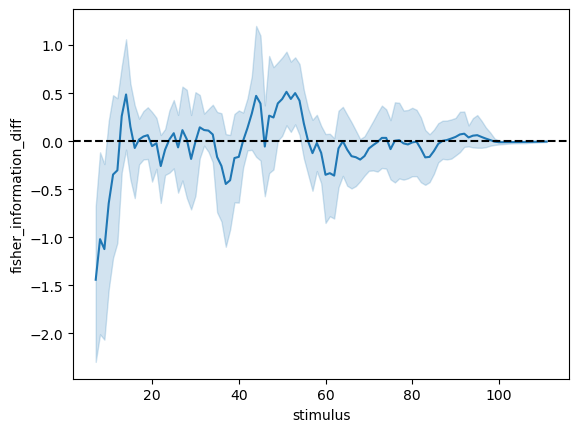

In [143]:
sns.lineplot(x='stimulus', y='fisher_information_diff', data=fisher_information_diff.reset_index())
plt.axhline(0.0, c='k', ls='--')

(5.0, 28.0)

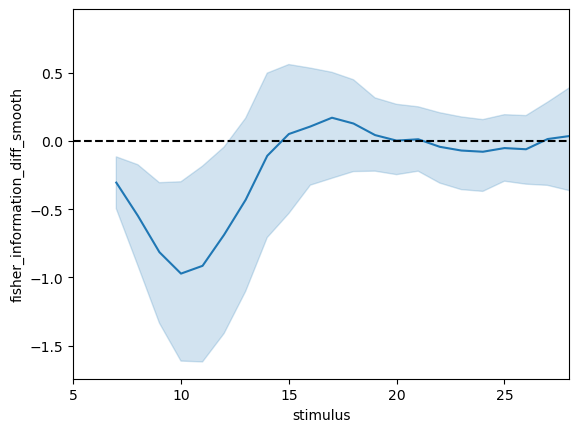

In [147]:
sns.lineplot(x='stimulus', y='fisher_information_diff_smooth', data=fisher_information_diff.reset_index(), errorbar=('ci', 95))
plt.axhline(0.0, c='k', ls='--')

plt.xlim(5, 28)

In [135]:
from scipy.interpolate import interp1d

def resample_to_fisher_grid(d):
    # print(d)
    x = np.arange(7, 111)
    interp = interp1d(d.index.get_level_values('x'), d, kind='linear')

    return pd.Series(interp(x), index=pd.Index(x,name='stimulus'))

# interp1d(tmp.index, tmp['sd'], kind='linear')(np.linspace(7, 112))

cognitive_noise_diff_resampled = cognitive_noise_diff.groupby('subject')['sd'].apply(resample_to_fisher_grid)

<Axes: xlabel='stimulus', ylabel='r'>

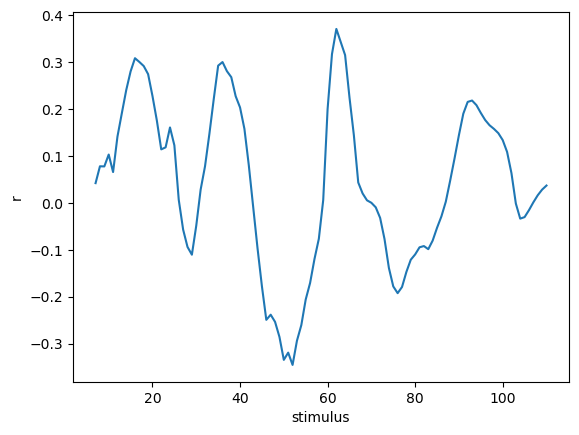

In [137]:
tmp = cognitive_noise_diff_resampled.to_frame('cognitive_noise_diff').join(fisher_information_diff)


r = tmp[np.isfinite(tmp).all(1)].groupby('stimulus').apply(lambda d: pingouin.corr(d['cognitive_noise_diff'], d['fisher_information_diff_smooth']))

sns.lineplot(x='stimulus', y='r', data=r.reset_index())